In [1]:
from bs4 import BeautifulSoup
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
all_rows=[]

for gender in ['men','women']:
    gender_url=f'https://www.alltime-athletics.com/{gender}.htm'
    html=requests.get(gender_url,headers).content
    soup=BeautifulSoup(html)

    disciplines=['100 metres', '200 metres', '400 metres', '800 metres', '1500 metres', '1 mile', '3000 metres', '10000 metres','half-marathon', 'marathon']
    discipline_urls={e.text:'https://www.alltime-athletics.com/'+e['href'] for e in soup.select('x x') if e.text in disciplines and 'ok' in e['href']}

    for discipline, discipline_url in discipline_urls.items():
        html=requests.get(discipline_url,headers).content
        soup=BeautifulSoup(html)
        
        table=soup.select_one('center pre')
        rows=[tr.strip() for tr in table.text.split('\n') if tr!='']
        cleaned_rows=[]
        for row in rows:
            cleaned_row=[i for i in row.split(' ') if i !='']
            cleaned_row = [i for idx, i in enumerate(cleaned_row) if not (idx == 2 and ('-' in i or '+' in i or '±' in i))]

            cleaned_row.insert(0, gender)
            cleaned_row.insert(0,discipline)
            
            cleaned_rows.append(cleaned_row)
        all_rows.extend(cleaned_rows)

        print(f'Gender : {gender}, Discipline : {discipline}',end='\r')

In [3]:
df=pd.DataFrame(all_rows)

In [4]:
date_df=df[[10,11,12,13,14,15,16,17]]

dates = []

for idx in date_df.index:
    parsed = False
    for col in date_df.columns:
        value = date_df.loc[idx, col]
        try:
            date_obj = datetime.strptime(value, '%d.%m.%Y').date()
            date_str = date_obj.strftime('%d.%m.%Y')
            dates.append(date_str)
            parsed = True
            break
        except:
            continue
    if not parsed:
        dates.append(None)

df['Date']=dates
df['Date']=pd.to_datetime(df['Date'])

In [5]:
nan_columns=list(df.isna().mean()[df.isna().mean()>0.5].index)
df=df.drop(columns=nan_columns)

In [6]:
df=df.drop(columns=[2,7,8,9,10])

In [7]:
df.columns=['Discipline', 'Gender', 'Time', 'First Name', 'Last Name', 'Country','Date']

In [8]:
runners=df['First Name']+' '+df['Last Name']
df.insert(2, 'Runner', runners)
df=df.drop(columns=['First Name', 'Last Name'])

In [9]:
df['Time']=df['Time'].str.replace('A','').str.replace('y','').str.replace('+','').str.replace('a','').str.replace('@','').str.replace('d','').str.replace('#','')


df['Time']=df['Time'].apply(lambda x:
                float(x.split(':')[0])*36000+float(x.split(':')[1])*6000+float(x.split(':')[2])*100 if isinstance(x,str) and x.count(':')==2 else
                float(x.split(':')[0])*6000+float(x.split(':')[1])*100 if isinstance(x,str) and x.count(':')==1 else
                float(x)*100 if isinstance(x,str) and x.count(':')==0 else None
                ).apply(pd.to_numeric)/100

In [10]:
df=df[df['Discipline']!='half-marathon']
df=df[df['Discipline']!='marathon']

In [11]:
df.to_csv('runners.csv',index=False)

In [12]:
df=pd.read_csv('runners.csv')

In [13]:
df

,Discipline,Gender,Runner,Time,Country,Date
0,100 metres,men,Usain Bolt,9.58,JAM,2009-08-16
1,100 metres,men,Usain Bolt,9.63,JAM,2012-08-05
2,100 metres,men,Usain Bolt,9.69,JAM,2008-08-16
3,100 metres,men,Tyson Gay,9.69,USA,2009-09-20
4,100 metres,men,Yohan Blake,9.69,JAM,2012-08-23
...,...,...,...,...,...,...
67944,10000 metres,women,Marina Bastos,1929.95,POR,1997-04-05
67945,10000 metres,women,Yoko Yagi,1929.95,JPN,2005-06-17
67946,10000 metres,women,Wang Xueqin,1929.95,CHN,2013-09-11
67947,10000 metres,women,Yuko Kawakami,1929.97,JPN,1999-10-03


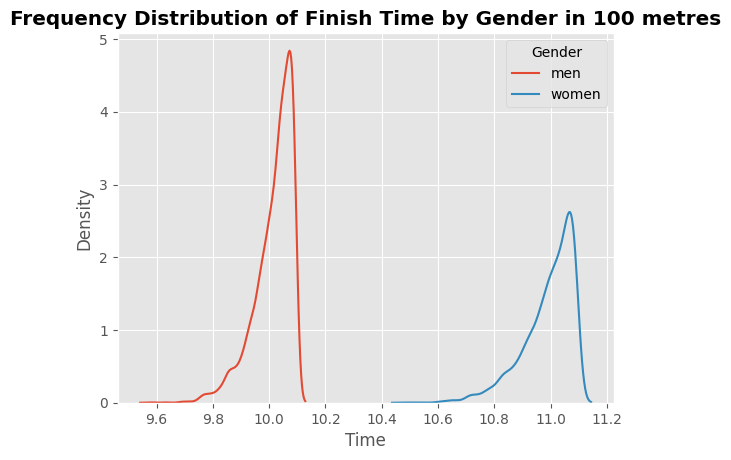

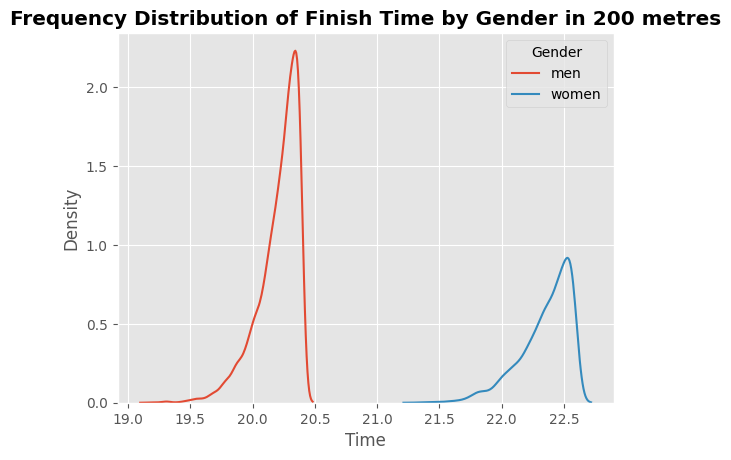

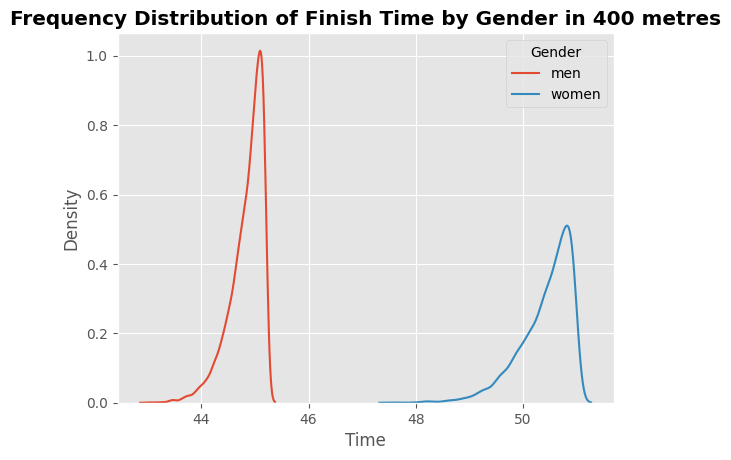

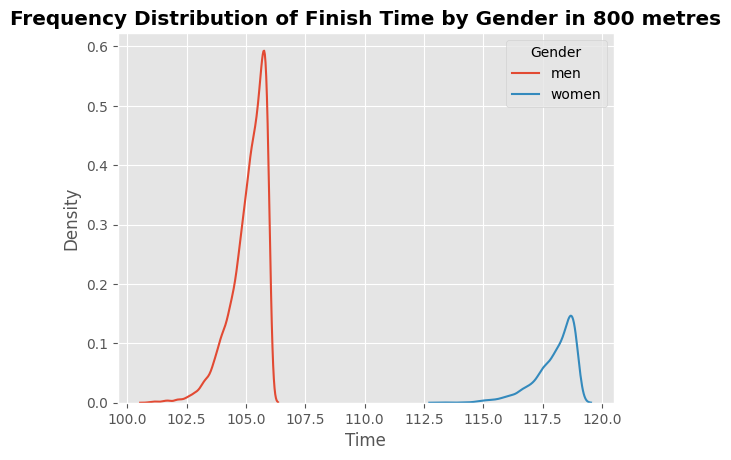

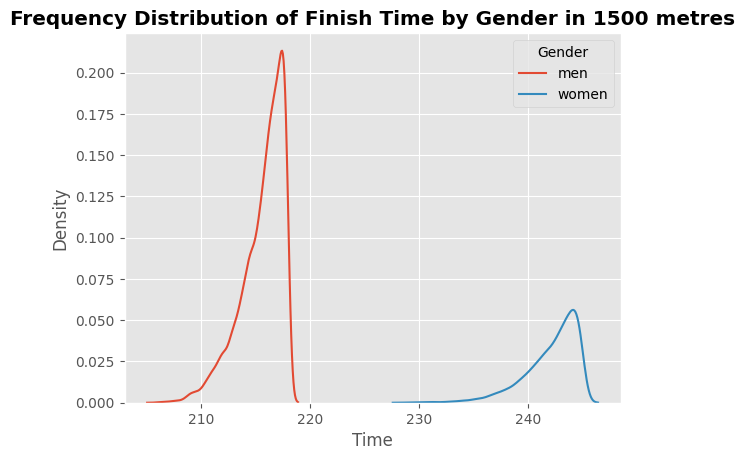

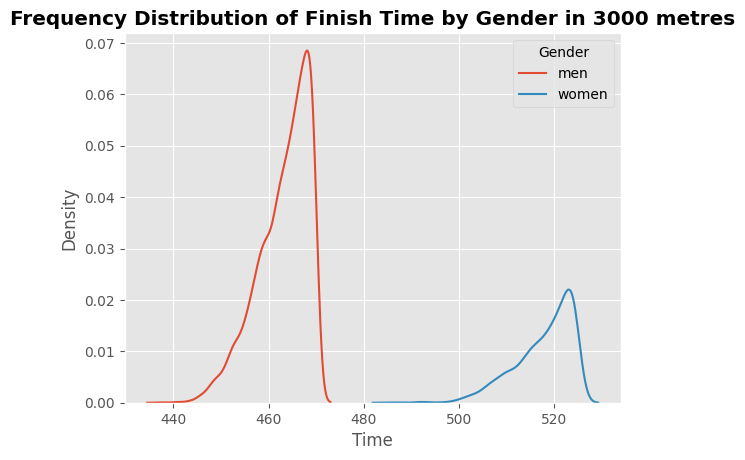

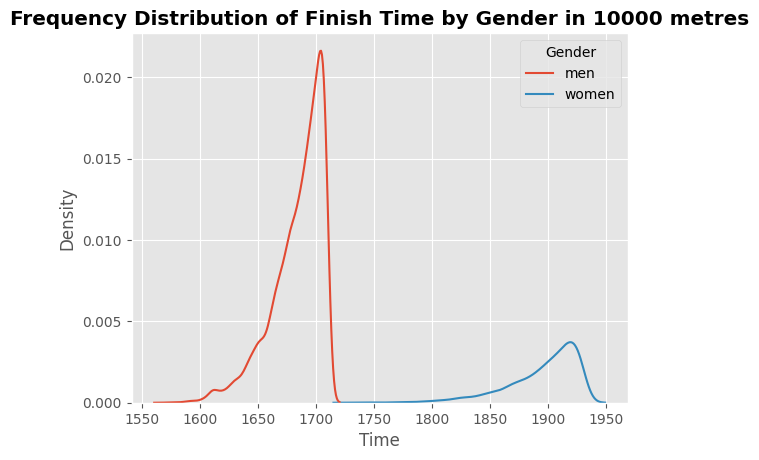

In [14]:
for discipline in df['Discipline'].unique():

    filtered=df[df['Discipline']==discipline]

    sns.kdeplot(filtered, x='Time',hue='Gender')
    plt.title(f'Frequency Distribution of Finish Time by Gender in {discipline}',fontweight='bold')
    plt.show()


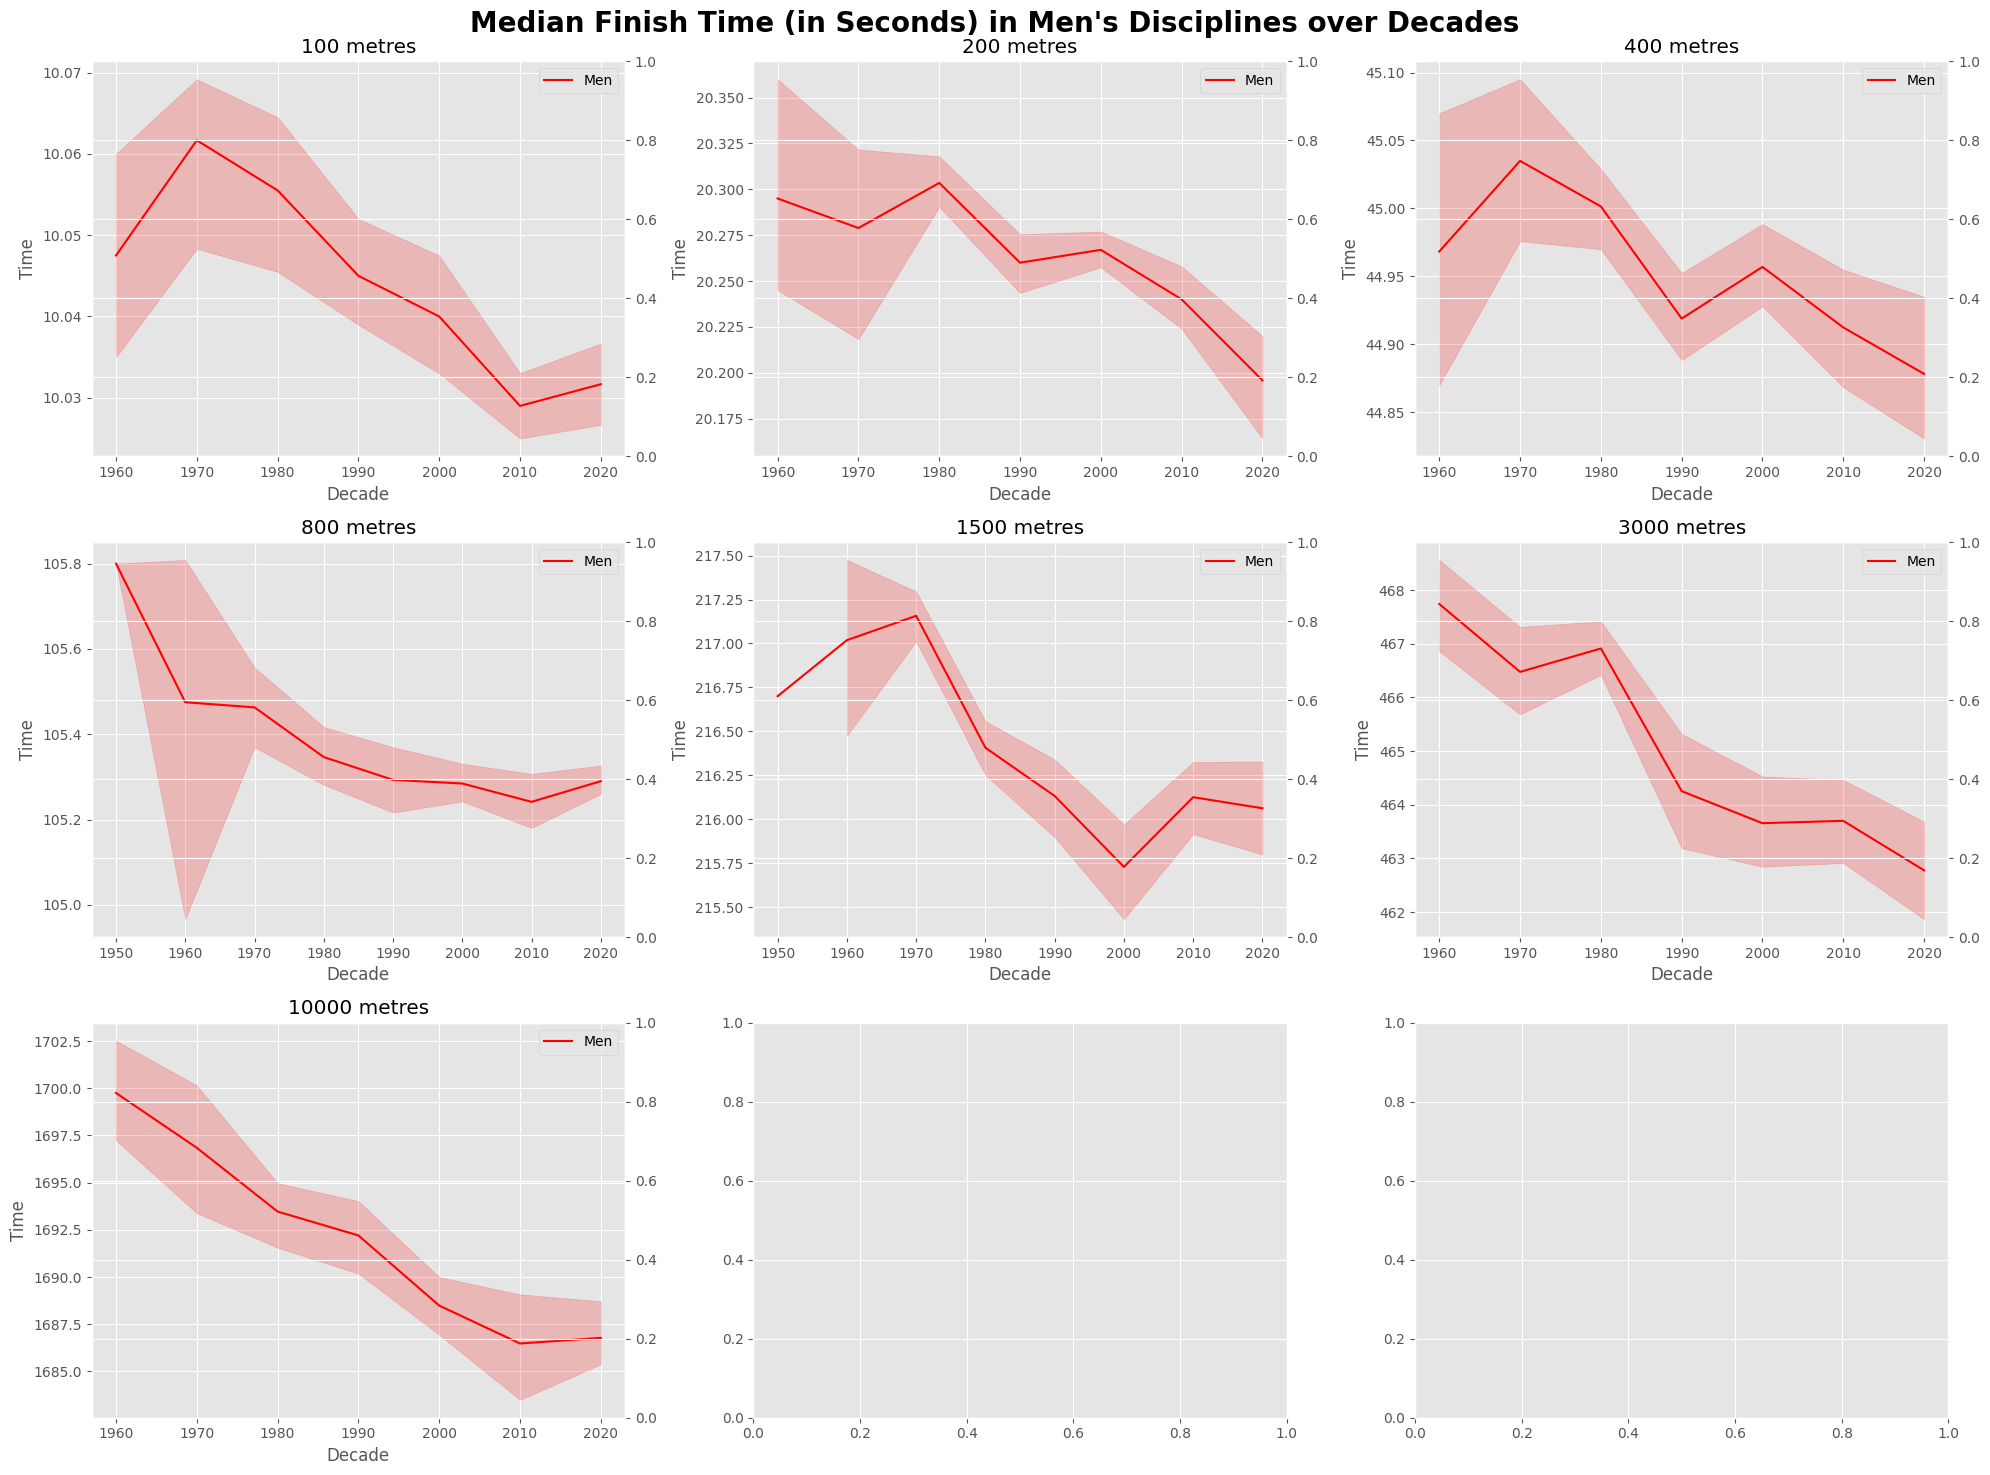

In [15]:
df['Date']=pd.to_datetime(df['Date'])

grouped=df.groupby(['Discipline','Gender',df['Date'].dt.year])['Time'].median().reset_index()

grouped['Decade'] = (grouped['Date'] // 10) * 10
grouped['Decade']=grouped['Decade'].astype('int64')


fig, axes=plt.subplots(3,3, figsize=(20,15))
disciplines=grouped.sort_values('Time')['Discipline'].unique()

for ax, discipline in zip(axes.flatten(), disciplines):

    filtered=grouped[grouped['Discipline']==discipline]
    men_filtered=filtered[filtered['Gender']=='men']
    women_filtered=filtered[filtered['Gender']=='women']

    ax2=ax.twinx()
    sns.lineplot(men_filtered, x='Decade', y='Time',color='Red',label='Men',ax=ax)
    #sns.lineplot(women_filtered, x='Decade', y='Time',color='Blue',label='Women',ax=ax2)
    
    #ax.set_ylim(filtered['Time'].min())
    #ax2.set_ylim(filtered['Time'].min())

    ax.set_title(f'{discipline}')

plt.suptitle("Median Finish Time (in Seconds) in Men's Disciplines over Decades",fontweight='bold',size=20)
plt.tight_layout()
plt.show()


In [16]:
grouped=df.groupby(['Discipline', 'Gender', 'Country'])['Time'].min().reset_index().sort_values('Time').groupby(['Discipline','Gender']).head(1).reset_index(drop=True)

print('Leading countries in each discipline :')
grouped

Leading countries in each discipline :


,Discipline,Gender,Country,Time
0,100 metres,men,JAM,9.58
1,100 metres,women,USA,10.49
2,200 metres,men,JAM,19.19
3,200 metres,women,USA,21.34
4,400 metres,men,Niekerk,43.03
5,400 metres,women,GDR,47.60
6,800 metres,men,KEN,100.91
7,800 metres,women,CZE,113.28
8,1500 metres,men,Guerrouj,206.00
9,1500 metres,women,KEN,229.04
